In [1]:
'''
Import the packages needed for classification
'''
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
import sklearn.metrics as metrics
import PIL
plt.close()

In [2]:
'''
Set directory parameters
'''
# Set the directories for the data and the CSV files that contain ids/labels
dir_train_images  = './data/training/'
dir_test_images   = './data/testing/'
dir_train_labels  = './data/labels_training.csv'
dir_test_ids      = './data/sample_submission.csv'

In [3]:
'''
Include the functions used for loading, preprocessing, features extraction, 
classification, and performance evaluation
'''

def load_data(dir_data, dir_labels, training=True):
    ''' Load each of the image files into memory 

    While this is feasible with a smaller dataset, for larger datasets,
    not all the images would be able to be loaded into memory

    When training=True, the labels are also loaded
    '''
    labels_pd = pd.read_csv(dir_labels)
    ids       = labels_pd.id.values
    data      = []
    for identifier in ids:
        fname     = dir_data + identifier.astype(str) + '.tif'
        image     = mpl.image.imread(fname)
        data.append(image)
    data = np.array(data) # Convert to Numpy array
    if training:
        labels = labels_pd.label.values
        return data, labels
    else:
        return data, ids


def cv_performance_assessment(X,y,k,clf):
    '''Cross validated performance assessment
    
    X   = training data
    y   = training labels
    k   = number of folds for cross validation
    clf = classifier to use
    
    Divide the training data into k folds of training and validation data. 
    For each fold the classifier will be trained on the training data and
    tested on the validation data. The classifier prediction scores are 
    aggregated and output
    '''
    # Establish the k folds
    prediction_scores = np.empty(y.shape[0],dtype='object')
    kf = StratifiedKFold(n_splits=k, shuffle=True)
    for train_index, val_index in kf.split(X, y):
        # Extract the training and validation data for this fold
        X_train, X_val   = X[train_index], X[val_index]
        y_train          = y[train_index]
        
        # Train the classifier
        X_train_features = preprocess_and_extract_features(X_train)
        clf              = clf.fit(X_train_features,y_train)
        
        # Test the classifier on the validation data for this fold
        X_val_features   = preprocess_and_extract_features(X_val)
        cpred            = clf.predict_proba(X_val_features)
        
        # Save the predictions for this fold
        prediction_scores[val_index] = cpred[:,1]
    return prediction_scores

def plot_roc(labels, prediction_scores):
    fpr, tpr, _ = metrics.roc_curve(labels, prediction_scores, pos_label=1)
    auc = metrics.roc_auc_score(labels, prediction_scores)
    legend_string = 'AUC = {:0.3f}'.format(auc)
   
    plt.plot([0,1],[0,1],'--', color='gray', label='Chance')
    plt.plot(fpr, tpr, label=legend_string)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid('on')
    plt.axis('square')
    plt.legend()
    plt.tight_layout()


In [4]:
def preprocess_and_extract_features(data):
    '''Preprocess data and extract features
    
    Preprocess: normalize, scale, repair
    Extract features: transformations and dimensionality reduction
    '''
    
    
    return data


In [26]:
from sklearn import svm
def set_classifier():
    '''Shared function to select the classifier for both performance evaluation
    and testing
    '''
    svmClassifier = svm.SVC(kernel='rbf', degree = 3, probability=True, C=1, gamma='scale')
    knn = KNeighborsClassifier(n_neighbors=20)
    
    return svmClassifier

In [28]:
'''
Load data
'''
# Set parameters for the analysis
num_training_folds = 10

# Load the data
data, labels = load_data(dir_train_images, dir_train_labels, training=True)


## My playground

In [35]:
from sklearn import decomposition

def preprocess_and_extract_features_PCA(data):
    '''Preprocess data and extract features
    
    Preprocess: normalize, scale, repair
    Extract features: transformations and dimensionality reduction
    '''
    # Here, we do something trivially simple: we take the average of the RGB
    # values to produce a grey image, transform that into a vector, then
    # extract the mean and standard deviation as features.
    
    # Make the image grayscale
    #data = np.mean(data, axis=3)
    
    # Vectorize the grayscale matrices
    vectorized_data = data.reshape(data.shape[0],-1)
    
    
    return vectorized_data

In [120]:
from sklearn import decomposition
from sklearn.manifold import TSNE

def preprocess_and_extract_features_TSNE(data, PCA_dimen, tSNE_dimen):
    '''Preprocess data and extract features
    
    Preprocess: normalize, scale, repair
    Extract features: transformations and dimensionality reduction
    '''
    # Reduce dimension by PCA first then do tSNE
    
    # Make the image grayscale
    data = np.mean(data, axis=3)
    
    # Vectorize the grayscale matrices
    vectorized_data = data.reshape(data.shape[0],-1)
    
    # Doing PCA on the data
    pca = decomposition.PCA(n_components=PCA_dimen)
    pca.fit(vectorized_data)
    print("{} of Variance is explained by first {} dimensions".format(sum(pca.explained_variance_ratio_), PCA_dimen))
    features = pca.transform(vectorized_data)
    features = TSNE(n_components = tSNE_dimen,perplexity=20,random_state=123).fit_transform(features)

    return features

## End of my playground

In [24]:
# Training
data_pca = preprocess_and_extract_features_PCA(data, PCA_dimen = 250)



0.8514970418635396 of Variance is explained by first 250 dimensions


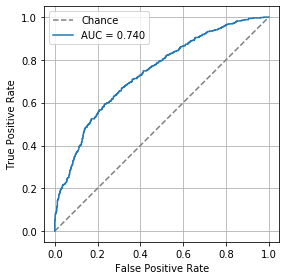

In [29]:
# Choose which classifier to use
clf = set_classifier()

# Perform cross validated performance assessment
prediction_scores = cv_performance_assessment(data_pca,labels,num_training_folds,clf)

# Compute and plot the ROC curves
plot_roc(labels, prediction_scores)

In [38]:
'''
Sample script for producing a Kaggle submission
'''

produce_submission = True # Switch this to True when you're ready to create a submission for Kaggle

if produce_submission:
    # Load data, extract features, and train the classifier on the training data
    training_data, training_labels = load_data(dir_train_images, dir_train_labels, training=True)
    training_features              = preprocess_and_extract_features_PCA(training_data)
    # Doing PCA on the data
    pca = decomposition.PCA(n_components=250)
    pca.fit(training_features)
    training_features = pca.transform(training_features)
    print(sum(pca.explained_variance_ratio_))
    clf                            = set_classifier()
    clf.fit(training_features,training_labels)

    # Load the test data and test the classifier
    test_data, ids = load_data(dir_test_images, dir_test_ids, training=False)
    test_features  = preprocess_and_extract_features_PCA(test_data)
    test_features = pca.transform(test_features)
    test_scores    = clf.predict_proba(test_features)[:,1]

    # Save the predictions to a CSV file for upload to Kaggle
    submission_file = pd.DataFrame({'id':    ids,
                                   'score':  test_scores})
    submission_file.to_csv('submission_PCA_SVM_3C.csv',
                           columns=['id','score'],
                           index=False)

0.8515527130929474


In [31]:
clf.predict_proba(training_features)[:,1]

array([0.24567833, 0.1468273 , 0.60638069, ..., 0.39492848, 0.15662055,
       0.78240103])

In [33]:
training_labels

array([0, 0, 1, ..., 0, 0, 1])

In [34]:
test_scores

array([0.25035713, 0.26394972, 0.27720277, 0.36624498, 0.35901471,
       0.31662154, 0.15739345, 0.21893525, 0.70646536, 0.36683855,
       0.3788102 , 0.74143   , 0.13735949, 0.53479192, 0.20557114,
       0.21024436, 0.32844968, 0.21407405, 0.11548737, 0.18013248,
       0.43943794, 0.37109322, 0.47096621, 0.56791726, 0.28924246,
       0.16146293, 0.23978933, 0.18697659, 0.18629129, 0.45606334,
       0.23293661, 0.56231059, 0.1800669 , 0.34264674, 0.32207932,
       0.18529128, 0.36693614, 0.21348228, 0.55387625, 0.60950677,
       0.55249525, 0.82533338, 0.46376428, 0.17595297, 0.25935265,
       0.57775813, 0.26558589, 0.65189274, 0.20575309, 0.27424667,
       0.4912144 , 0.31903299, 0.46318611, 0.68816613, 0.55520913,
       0.45618285, 0.20459793, 0.64550035, 0.43146711, 0.27563507,
       0.2531911 , 0.12122729, 0.61067291, 0.22242324, 0.54002485,
       0.13500406, 0.55163114, 0.21555941, 0.2918732 , 0.1052617 ,
       0.2456285 , 0.30752229, 0.63123522, 0.2300237 , 0.18847